# Trying stuff with gpt models
    

In [49]:
%load_ext autoreload
%autoreload 2

from earplugenv import EarplugEnv

from utils.env import plot_env

import termtables as tt 
import numpy as np 

from gpt import ChatApp



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
def cell_type_to_char(cell_type):
    if cell_type == "floor":
        return "F"
    elif cell_type == "wall":
        return "W"
    elif cell_type == "goal":
        return "G"
    else:
        raise ValueError("unknown cell type")
    
def env_to_str(env):
    grid_list = []

    for cell in env.grid.grid:
        try:
            grid_list.append(cell.type)
        except AttributeError:
            grid_list.append("floor")

    # calculate the side length of the square array
    n = int(np.sqrt(len(grid_list)))

    grid_arr = np.array(list(map(cell_type_to_char, grid_list))).reshape(n, n)
    grid_arr[env.agent_pos] = "Y"

    grid_str = tt.to_string(
        grid_arr,
        style=tt.styles.ascii_thin,
    )

    return grid_str

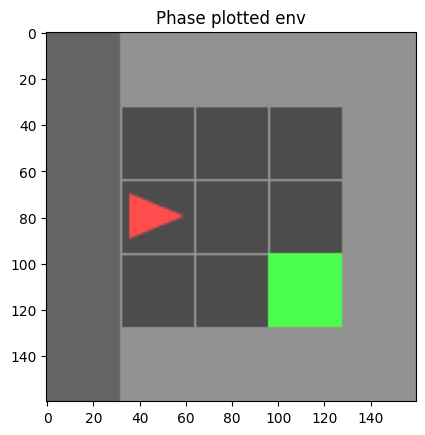

In [51]:
env = EarplugEnv(phase=3, size=5, render_mode="rgb_array")
env.reset()
plot_env(env)

In [52]:
grid = env_to_str(env)
print(grid)

+---+---+---+---+---+
| W | W | W | W | W |
+---+---+---+---+---+
| W | F | Y | F | W |
+---+---+---+---+---+
| W | F | F | F | W |
+---+---+---+---+---+
| W | F | F | G | W |
+---+---+---+---+---+
| W | W | W | W | W |
+---+---+---+---+---+


In [56]:
system_text = """ 
        You are an agent that acts in a grid world.

        Description: You want to get to the goal. 

        The W means Wall, which you can't walk to.
        The F means Floor, which you can walk over. 
        The Y means You, which indicates your position. 
        The G means Goal, which is where you have to go. 

        Actions: There are four actions available
            1 is move North
            2 is move East
            3 is move South
            4 is move West.

        I will give you the grid and the reward
        Then, you need to take an action.
        Only specify one number of {1, 2, 3, 4} as your output. 
        Do not say anything else.
        """
system_text.s

" \n        You are an agent that acts in a grid world.\n\n        Description: You want to get to the goal. \n\n        The W means Wall, which you can't walk to.\n        The F means Floor, which you can walk over. \n        The Y means You, which indicates your position. \n        The G means Goal, which is where you have to go. \n\n        Actions: There are four actions available\n            1 is move North\n            2 is move East\n            3 is move South\n            4 is move West.\n\n        I will give you the grid and the reward\n        Then, you need to take an action.\n        Only specify one number of {1, 2, 3, 4} as your output. \n        Do not say anything else.\n        "

In [60]:
# gpt = ChatApp(system_text=system_text.strip())
gpt = ChatApp(system_text="horse")

max_steps = 5
i = 0 
actions = []
reward = 0

env.reset()

while i < max_steps:
    grid_str = env_to_str(env)
    
    prompt = f"""
    This is the grid: 
    {grid_str}
    Reward: {reward}

    What is your action?
    """
    action = gpt.chat(prompt)

    obs, reward, terminated, truncated, info = env.step(int(action))

    actions.append(action)
    i += 1

actions

TypeError: ChatApp.__init__() got an unexpected keyword argument 'system_text'